#**Avance 2. Ingeniería de Características**

###**Maestría en Inteligencia Artificial Aplicada**
###**Curso: Proyecto Integrador**
###**Tecnológico de Monterrey**
###**Prof. Dra. Grettel Barceló Alonso**

###**Equipo 4**

####**A01166618 Rogelio Rivera Meléndez**
####**A01794708 Juan José Hurtado Ordoñez**
####**A00439670 Ignacio Sáyago Vela**

**INTRODUCCIÓN**


En este documento se lleva a cabo la ingeniería de características para la funcionalidad del sistema por desarollar, que pretende determinar si un reclamo por siniestro de vehículo es fraudulento o legítimo mediante técnicas de machine learning.

Para ello se trabajó en el análisis exploratorio de datos utilizando una base de datos generada por Oracle, que contiene 15420 registros con los datos de la póliza de seguro y el reporte de siniestro para reclamos presentados a seguradoras tanto legítimos como fraudulentos (https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection).

A partir de este análisis, se eliminaron algunas variables que contenían información duplicada, se imputaron valores faltantes, se analizaron las variables numéricas y categóricas binarias, nominales y ordinales. Asimismo se detectó que existe un desbalanceo de clases en la variable dependiente, y se aplicaron las transformaciones y escalamientos necesarios para normalizar los datos y procurar que tuvieran una distribución más aproximada a una gaussiana. Finalmente se crearon los conjutnos de entrenamiento, validación y prueba.

A continuación, se procederá a explorar métodos de filtrado para la selección de características que permita reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento.

Cabe mencionar que para las otras funcionalidades del sistema no se requiere llevar a cabo un análisis exploratorio de datos puesto que se emplearán técnicas de deep learning y visión computacional, utilizando conjuntos de datos que constan de imágenes que ya han sido preprocesadas.    


**IMPORTACIÓN DE LIBRERÍAS**

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from tabulate import tabulate

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor

##**1) Carga de los dataframes generados en el Análisis Exploratorio de Datos**

In [2]:
# Se importa el archivo ZIP cargado en nuestro repositorio de Github que contiene los dataframes generados en la actividad anterior

!wget https://github.com/IgnacioSay/Dataset_Deteccion_Fraude/archive/refs/heads/main.zip

!unzip /content/main.zip




--2025-05-09 05:06:13--  https://github.com/IgnacioSay/Dataset_Deteccion_Fraude/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/IgnacioSay/Dataset_Deteccion_Fraude/zip/refs/heads/main [following]
--2025-05-09 05:06:13--  https://codeload.github.com/IgnacioSay/Dataset_Deteccion_Fraude/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.116.9
Connecting to codeload.github.com (codeload.github.com)|140.82.116.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ]   2.92M  8.17MB/s    in 0.4s    

2025-05-09 05:06:14 (8.17 MB/s) - ‘main.zip’ saved [3066198]

Archive:  /content/main.zip
35aa7744b994144632c2696c8cae23aeff5b27ae
   creating: Dataset_Deteccion_

In [3]:
!unzip /content/Dataset_Deteccion_Fraude-main/data/my_data.zip

Archive:  /content/Dataset_Deteccion_Fraude-main/data/my_data.zip
 extracting: content/Dataset_Deteccion_Fraude-main/df.pkl  
 extracting: content/Dataset_Deteccion_Fraude-main/df_train_T.pkl  
 extracting: content/Dataset_Deteccion_Fraude-main/XtrainT.pkl  
 extracting: content/Dataset_Deteccion_Fraude-main/XvalT.pkl  
 extracting: content/Dataset_Deteccion_Fraude-main/XtestT.pkl  
 extracting: content/Dataset_Deteccion_Fraude-main/ytrainT.pkl  
 extracting: content/Dataset_Deteccion_Fraude-main/yvalT.pkl  
 extracting: content/Dataset_Deteccion_Fraude-main/ytestT.pkl  


In [4]:
# Se crean los dataframes vacíos

df_names = ['df','df_train_T','XtrainT','XvalT', 'XtestT', 'ytrainT', 'yvalT', 'ytestT']

for df_name in df_names:
  globals()[df_name] = pd.DataFrame()


In [5]:
# Se cargan los archivos Pickle en sus respectivos dataframes

import pickle

path = '/content/content/Dataset_Deteccion_Fraude-main/'

df_list = [df, df_train_T, XtrainT, XvalT, XtestT, ytrainT, yvalT, ytestT]


if len(df_names) == len(df_list):
  for i, df_name in enumerate(df_names):
    with open(path + df_name + '.pkl', 'rb') as file:

        if df_name == 'df':
          df = pickle.load(file)
        if df_name == 'df_train_T':
          df_train_T = pickle.load(file)
        if df_name == 'XtrainT':
          XtrainT = pickle.load(file)
        if df_name == 'XvalT':
          XvalT = pickle.load(file)
        if df_name == 'XtestT':
          XtestT = pickle.load(file)
        if df_name == 'ytrainT':
          ytrainT = pickle.load(file)
        if df_name == 'yvalT':
          yvalT = pickle.load(file)
        if df_name == 'ytestT':
          ytestT = pickle.load(file)


In [6]:
display(df.head(5))
display(df_train_T.head(5))
display(XtrainT.head(5))
display(XvalT.head(5))
display(XtestT.head(5))
display(ytrainT.head(5))
display(yvalT.head(5))
display(ytestT.head(5))


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


,WeekOfMonth,WeekOfMonthClaimed,Deductible,DriverRating,Year,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,...,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,VehicleCategory_Sport,VehicleCategory_Utility,FraudFound_P
12012,0.443314,0.472860,0.5,0.52714,1.000000,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1149,0.513435,0.527140,0.5,0.52714,0.000000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11427,0.513435,0.593033,0.5,0.47286,1.000000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3476,0.443314,0.527140,0.5,0.47286,0.000000,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
6678,0.513435,0.527140,0.5,0.52714,0.513435,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


,WeekOfMonth,WeekOfMonthClaimed,Deductible,DriverRating,Year,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,...,RepNumber_2,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,VehicleCategory_Sport,VehicleCategory_Utility
12012,0.443314,0.472860,0.5,0.52714,1.000000,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1149,0.513435,0.527140,0.5,0.52714,0.000000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11427,0.513435,0.593033,0.5,0.47286,1.000000,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3476,0.443314,0.527140,0.5,0.47286,0.000000,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
6678,0.513435,0.527140,0.5,0.52714,0.513435,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,WeekOfMonth,WeekOfMonthClaimed,Deductible,DriverRating,Year,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,...,RepNumber_2,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,VehicleCategory_Sport,VehicleCategory_Utility
9475,0.513435,0.527140,0.5,0.52714,0.513435,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3691,0.000000,0.472860,0.5,1.00000,0.000000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4061,0.593033,0.593033,1.0,1.00000,0.000000,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3096,0.513435,0.593033,0.5,0.00000,0.000000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7021,0.593033,0.527140,0.5,1.00000,0.513435,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


,WeekOfMonth,WeekOfMonthClaimed,Deductible,DriverRating,Year,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,...,RepNumber_2,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,VehicleCategory_Sport,VehicleCategory_Utility
9698,0.443314,0.472860,0.5,0.52714,0.513435,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10643,0.593033,0.593033,0.5,0.00000,0.513435,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
13129,0.593033,0.000000,0.5,0.52714,1.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3127,0.513435,0.593033,0.5,0.47286,0.000000,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
11710,0.000000,0.527140,0.5,0.52714,1.000000,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


,FraudFound_P
12012,0
1149,0
11427,0
3476,0
6678,0


,FraudFound_P
9475,0
3691,0
4061,0
3096,0
7021,0


,FraudFound_P
9698,0
10643,0
13129,1
3127,0
11710,0


#**PARTE 1: Análisis PCA**



In [7]:
total_components = XtrainT.shape[1]
print("El número total de componentes es: ", total_components)

El número total de componentes es:  64


In [8]:
# Se realiza el PCA empleando el conjunto de entrenamiento transformado

pca = PCA()
x_projected = pca.fit_transform(XtrainT)
x_projected = pd.DataFrame(x_projected)
x_projected.head(5)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.268786,-0.745997,0.039452,0.017163,-0.267381,0.621683,0.476639,-0.240650,-0.587944,0.057893,...,-0.002672,0.000702,-0.000391,0.003552,-0.002669,-0.002682,-0.000518,0.001474,0.000432,-1.163798e-15
1,-0.055742,-1.081870,-0.168689,-0.370122,0.151374,-0.370668,-0.333185,-0.598818,-0.554321,-0.088938,...,0.003734,0.000967,0.006329,0.002236,0.002328,0.000535,-0.000583,0.000521,-0.000954,1.453331e-16
2,-0.233102,0.551232,-0.026370,-0.014505,-0.119765,0.108052,0.475492,-0.006419,-0.999058,-0.105177,...,0.005441,-0.000485,-0.002190,0.002091,-0.001478,0.001521,-0.000159,0.000586,0.000779,2.497415e-17
3,-0.948366,0.352299,-0.168773,-0.068351,0.593112,-0.078944,-0.463275,0.174637,0.244579,0.144081,...,0.006572,0.006770,-0.003330,-0.010451,0.000920,-0.000547,-0.000347,-0.000317,0.000408,1.074702e-15
4,-0.701464,0.320153,-0.557440,0.367830,-0.641765,-0.100831,0.189496,-0.189748,0.307158,0.071850,...,-0.000079,0.002844,-0.000224,0.002554,0.001138,-0.001510,-0.000964,0.000547,-0.000019,2.395471e-16


In [9]:
print("Los eigen valores para la matriz de covarianza de nuestro conjunto de entrenamiento son:")

e_vals = list(np.round(pca.explained_variance_, decimals=5))

print(e_vals)

Los eigen valores para la matriz de covarianza de nuestro conjunto de entrenamiento son:
[np.float64(0.55256), np.float64(0.44192), np.float64(0.23117), np.float64(0.20287), np.float64(0.197), np.float64(0.1775), np.float64(0.16162), np.float64(0.15829), np.float64(0.13799), np.float64(0.12846), np.float64(0.12502), np.float64(0.1213), np.float64(0.09545), np.float64(0.09196), np.float64(0.08216), np.float64(0.07714), np.float64(0.07276), np.float64(0.06956), np.float64(0.06776), np.float64(0.06557), np.float64(0.06512), np.float64(0.06421), np.float64(0.06416), np.float64(0.06297), np.float64(0.06256), np.float64(0.06226), np.float64(0.06188), np.float64(0.06181), np.float64(0.06158), np.float64(0.06031), np.float64(0.05984), np.float64(0.0595), np.float64(0.05863), np.float64(0.05575), np.float64(0.05406), np.float64(0.05041), np.float64(0.03502), np.float64(0.02842), np.float64(0.0213), np.float64(0.01814), np.float64(0.01592), np.float64(0.01498), np.float64(0.01085), np.float64(0.

In [10]:
for i in range(0, total_components):
  print("El porcentaje de varianza explicado por el componente principal ", i+1, "es", format(pca.explained_variance_ratio_[i]*100,'.0f'),'%')

El porcentaje de varianza explicado por el componente principal  1 es 12 %
El porcentaje de varianza explicado por el componente principal  2 es 10 %
El porcentaje de varianza explicado por el componente principal  3 es 5 %
El porcentaje de varianza explicado por el componente principal  4 es 5 %
El porcentaje de varianza explicado por el componente principal  5 es 4 %
El porcentaje de varianza explicado por el componente principal  6 es 4 %
El porcentaje de varianza explicado por el componente principal  7 es 4 %
El porcentaje de varianza explicado por el componente principal  8 es 4 %
El porcentaje de varianza explicado por el componente principal  9 es 3 %
El porcentaje de varianza explicado por el componente principal  10 es 3 %
El porcentaje de varianza explicado por el componente principal  11 es 3 %
El porcentaje de varianza explicado por el componente principal  12 es 3 %
El porcentaje de varianza explicado por el componente principal  13 es 2 %
El porcentaje de varianza explic

In [11]:
#Se visualiza la suma acumulada de porcentajes para ver con cuántas características principales se obtiene el 95% de la varianza

np.cumsum(pca.explained_variance_ratio_)

array([0.12421487, 0.22355852, 0.27552594, 0.32113099, 0.36541775,
       0.40532086, 0.44165368, 0.4772368 , 0.50825677, 0.53713487,
       0.56523897, 0.59250821, 0.61396459, 0.63463651, 0.65310617,
       0.67044801, 0.68680443, 0.70244075, 0.71767236, 0.73241252,
       0.7470517 , 0.76148639, 0.77591003, 0.79006631, 0.80412886,
       0.81812588, 0.83203733, 0.84593267, 0.85977646, 0.87333336,
       0.88678633, 0.90016125, 0.91334118, 0.92587379, 0.93802617,
       0.94935732, 0.95722947, 0.96361737, 0.96840565, 0.97248299,
       0.97606173, 0.9794289 , 0.98186774, 0.98418849, 0.98634924,
       0.98825256, 0.99011965, 0.99175627, 0.99298834, 0.99414497,
       0.99526845, 0.99636801, 0.99725088, 0.9980959 , 0.99863863,
       0.99899521, 0.99928778, 0.9995757 , 0.99975479, 0.9998564 ,
       0.9999185 , 0.99997939, 1.        , 1.        ])

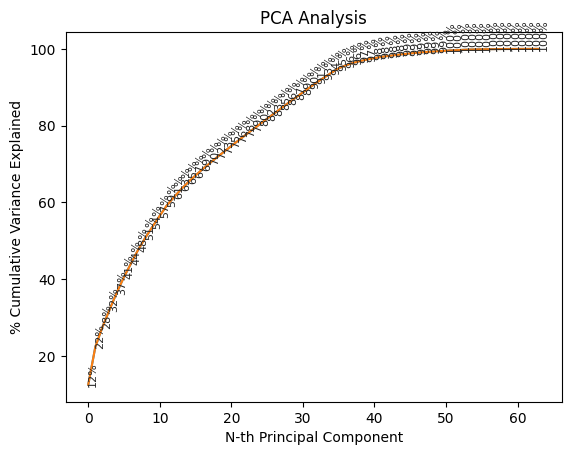

In [12]:
labels = np.cumsum(pca.explained_variance_ratio_)

cum_sum_frac = np.cumsum(pca.explained_variance_ratio_)
cum_sum_per =  [i* 100 for i in cum_sum_frac]
sns.lineplot(data=cum_sum_per)
sns.set_style("darkgrid")
plt.title('PCA Analysis')
plt.xlabel('N-th Principal Component')
import matplotlib.pyplot as plt
labels = np.cumsum(pca.explained_variance_ratio_)

cum_sum_frac = np.cumsum(pca.explained_variance_ratio_)
cum_sum_per =  [i* 100 for i in cum_sum_frac]
sns.lineplot(data=cum_sum_per)
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (20,3)
plt.title('PCA Analysis')
plt.xlabel('N-th Principal Component')
plt.ylabel('% Cumulative Variance Explained')
for i in range(total_components):
  plt.text(i,labels[i]*100,rotation=90,fontsize=8,s=str(format(labels[i]*100,'.0f'))+'%')

#**Podemos ver que las primeras 36 características conforman el 95% de la varianza**

In [13]:
# Se crea un dataframe seleccionando el número de componenetes que explica la mayor parte de la varianza
num_components = 36
pc_df = pd.DataFrame(abs(pca.components_[:num_components]), columns = XtrainT.columns, index=['Principal component {}'.format(i) for i in range(1, num_components + 1)])
pc_df

,WeekOfMonth,WeekOfMonthClaimed,Deductible,DriverRating,Year,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,...,RepNumber_2,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,VehicleCategory_Sport,VehicleCategory_Utility
Principal component 1,0.002892,0.005127,0.000067,0.000531,0.002655,0.029243,0.041034,0.148500,0.008994,0.002815,...,0.001714,0.001460,0.002729,0.000273,0.000851,0.003795,0.000728,0.000018,0.595159,0.010451
Principal component 2,0.004982,0.007887,0.005882,0.007918,0.006797,0.001611,0.094538,0.008000,0.006501,0.002560,...,0.002250,0.000679,0.002028,0.000715,0.000331,0.000156,0.001962,0.008378,0.061552,0.014511
Principal component 3,0.002396,0.015352,0.000921,0.006740,0.042413,0.016988,0.020846,0.003348,0.002315,0.003927,...,0.004362,0.004951,0.004324,0.012928,0.003725,0.003361,0.002215,0.001239,0.038387,0.013588
Principal component 4,0.015993,0.000482,0.001967,0.015282,0.050130,0.000290,0.095971,0.281037,0.004567,0.003122,...,0.009377,0.001498,0.000098,0.000695,0.007465,0.008243,0.000871,0.003642,0.096429,0.011223
Principal component 5,0.023629,0.008130,0.001023,0.028187,0.037888,0.026689,0.027983,0.860847,0.000833,0.009008,...,0.005924,0.005377,0.011111,0.001787,0.002512,0.009620,0.002529,0.001730,0.027436,0.010027
Principal component 6,0.006196,0.019353,0.001140,0.014375,0.091821,0.009016,0.058790,0.265438,0.015332,0.001926,...,0.002730,0.008794,0.000238,0.003860,0.000002,0.011330,0.007363,0.014806,0.065353,0.006611
Principal component 7,0.002023,0.011779,0.000360,0.050042,0.972145,0.022892,0.031928,0.052696,0.009258,0.003652,...,0.014555,0.019091,0.000463,0.006035,0.001339,0.020717,0.013071,0.017430,0.011589,0.013079
Principal component 8,0.009784,0.014790,0.001439,0.005606,0.149315,0.029263,0.227551,0.002268,0.001966,0.002340,...,0.003748,0.005216,0.019350,0.009765,0.002615,0.018975,0.002987,0.016593,0.025171,0.004406
Principal component 9,0.004663,0.022060,0.001609,0.122624,0.096885,0.077604,0.284170,0.217827,0.003839,0.002755,...,0.006199,0.002950,0.002576,0.004942,0.001445,0.011447,0.003751,0.002427,0.301942,0.137709
Principal component 10,0.002355,0.020976,0.000772,0.643865,0.030684,0.044291,0.696313,0.028263,0.012040,0.001037,...,0.009512,0.013683,0.002619,0.007210,0.006642,0.015443,0.015342,0.007210,0.050215,0.000624


¿Cuáles son las variables más importantes en el cálculo del primer componente?


In [14]:
pc_df.head(1)

,WeekOfMonth,WeekOfMonthClaimed,Deductible,DriverRating,Year,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,...,RepNumber_2,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,VehicleCategory_Sport,VehicleCategory_Utility
Principal component 1,0.002892,0.005127,0.000067,0.000531,0.002655,0.029243,0.041034,0.1485,0.008994,0.002815,...,0.001714,0.00146,0.002729,0.000273,0.000851,0.003795,0.000728,0.000018,0.595159,0.010451


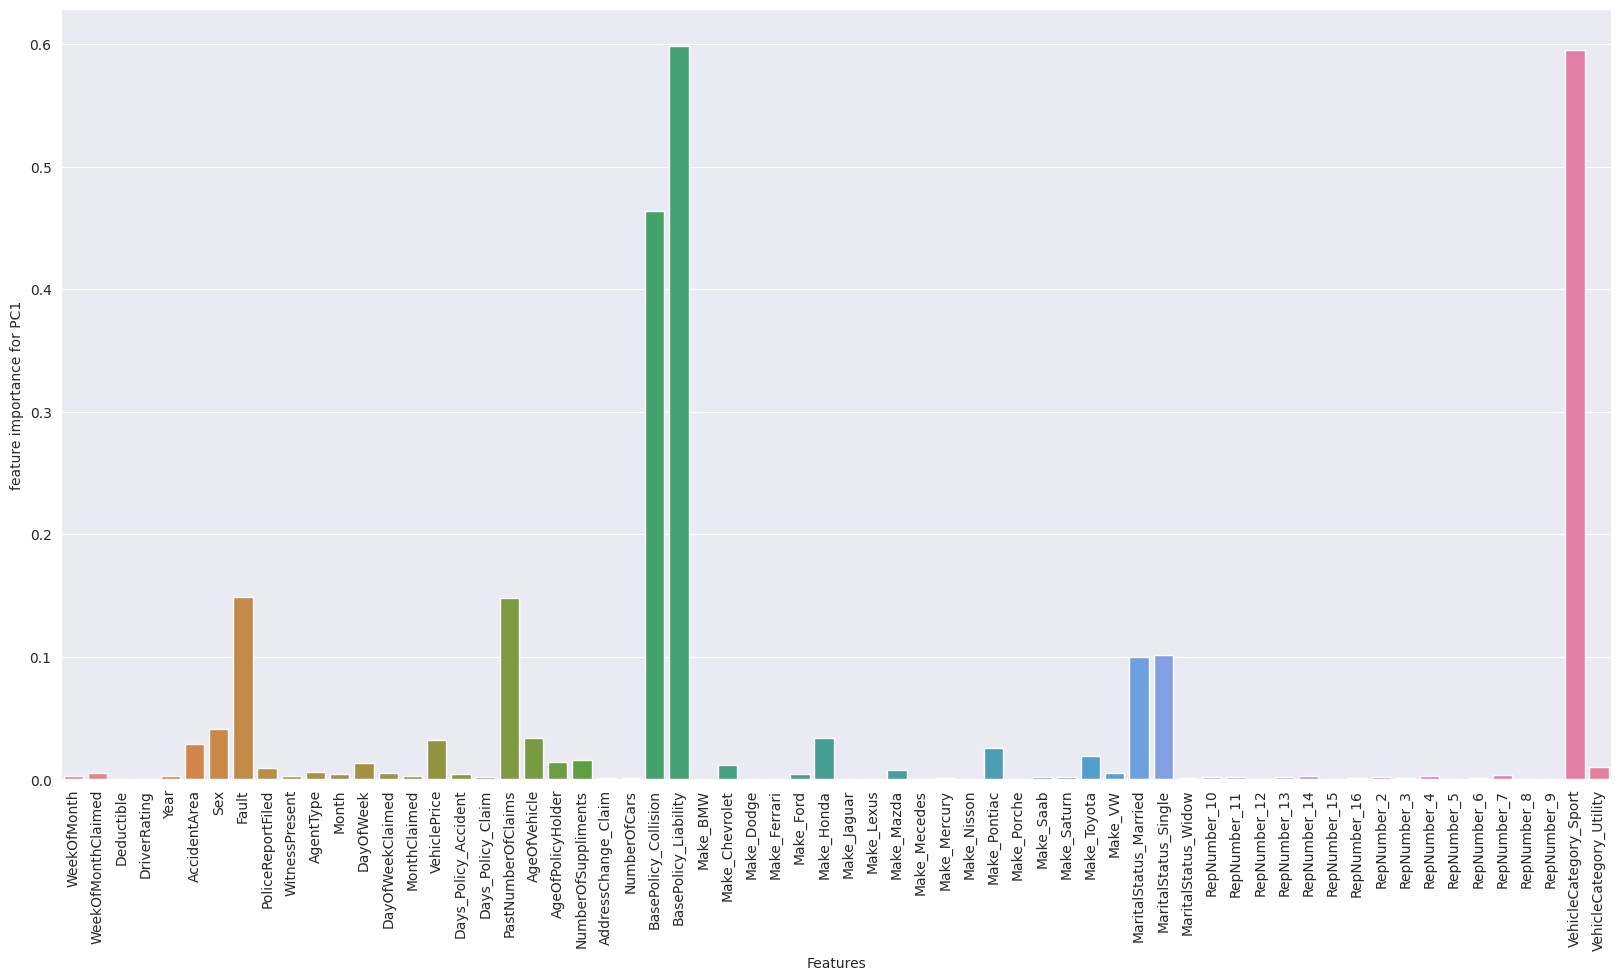

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=pc_df.iloc[0:1],errorbar=None)
plt.xlabel('Features')
plt.ylabel('feature importance for PC1')
plt.xticks(rotation=90)
plt.show()

In [16]:
# Se obtienen las variables más importantes para el cálculo de los primeros componentes

for i in range(num_components):
  first_row = pc_df.iloc[[i]]
  sorted_row = first_row.sort_values(by=first_row.index[0], axis=1, ascending=False)
  display(sorted_row)


,BasePolicy_Liability,VehicleCategory_Sport,BasePolicy_Collision,Fault,PastNumberOfClaims,MaritalStatus_Single,MaritalStatus_Married,Sex,AgeOfVehicle,Make_Honda,...,RepNumber_15,Make_Dodge,Make_BMW,Make_Mecedes,Make_Ferrari,RepNumber_12,Deductible,Make_Porche,RepNumber_9,Make_Lexus
Principal component 1,0.598421,0.595159,0.463719,0.1485,0.148213,0.101817,0.100249,0.041034,0.03388,0.033788,...,0.000246,0.000213,0.000211,0.000199,0.000122,0.000088,0.000067,0.000038,0.000018,0.0


,MaritalStatus_Married,MaritalStatus_Single,AgeOfVehicle,BasePolicy_Collision,Make_Honda,AgeOfPolicyHolder,Sex,BasePolicy_Liability,VehicleCategory_Sport,NumberOfSuppliments,...,RepNumber_6,Make_Jaguar,RepNumber_14,RepNumber_7,Make_Mecedes,AddressChange_Claim,Make_Ferrari,Make_Mercury,Make_Porche,Make_Lexus
Principal component 2,0.675398,0.669452,0.17363,0.132964,0.106356,0.095777,0.094538,0.082708,0.061552,0.052339,...,0.000331,0.000229,0.000218,0.000156,0.000095,0.000075,0.000066,0.000059,0.000038,0.0


,Make_Pontiac,Make_Toyota,Make_Honda,Make_Mazda,NumberOfSuppliments,BasePolicy_Collision,VehiclePrice,MaritalStatus_Married,MaritalStatus_Single,Make_Chevrolet,...,Make_Saturn,RepNumber_10,Make_Nisson,MaritalStatus_Widow,Make_BMW,Make_Jaguar,Make_Mecedes,Make_Porche,Make_Ferrari,Make_Lexus
Principal component 3,0.842643,0.438263,0.21976,0.106489,0.103376,0.079258,0.065342,0.05864,0.057786,0.051111,...,0.000899,0.000847,0.000502,0.000426,0.000183,0.00014,0.000126,0.000093,0.000028,0.0


,Make_Toyota,Make_Honda,BasePolicy_Collision,Fault,Make_Mazda,VehiclePrice,NumberOfSuppliments,Make_Pontiac,VehicleCategory_Sport,Sex,...,WeekOfMonthClaimed,AccidentArea,Make_Porche,Make_Ferrari,RepNumber_4,Make_Mecedes,NumberOfCars,Make_Jaguar,Make_BMW,Make_Lexus
Principal component 4,0.665787,0.512861,0.295848,0.281037,0.169889,0.157654,0.11311,0.107907,0.096429,0.095971,...,0.000482,0.00029,0.000251,0.000143,0.000098,0.000077,0.000067,0.000032,0.000003,1.262177e-29


,Fault,Make_Honda,BasePolicy_Collision,Make_Toyota,NumberOfSuppliments,PastNumberOfClaims,Make_Pontiac,Year,VehiclePrice,DriverRating,...,RepNumber_15,Make_BMW,DayOfWeek,Make_Porche,Make_Mecedes,Make_Nisson,Make_Ferrari,Make_Jaguar,Make_Saturn,Make_Lexus
Principal component 5,0.860847,0.281438,0.266925,0.220096,0.194461,0.102693,0.039815,0.037888,0.029597,0.028187,...,0.000535,0.000436,0.000396,0.000248,0.000235,0.000232,0.000203,0.000165,0.000026,0.0


,NumberOfSuppliments,Make_Mazda,Fault,Make_Honda,BasePolicy_Collision,Make_Toyota,Make_Pontiac,PastNumberOfClaims,Make_Chevrolet,Year,...,Make_BMW,MaritalStatus_Widow,Make_Mercury,RepNumber_13,Make_Jaguar,Make_Porche,RepNumber_4,Make_Ferrari,RepNumber_6,Make_Lexus
Principal component 6,0.731046,0.44349,0.265438,0.210903,0.175918,0.172632,0.167186,0.15018,0.092928,0.091821,...,0.00054,0.000518,0.000456,0.000352,0.000332,0.000272,0.000238,0.000082,0.000002,0.0


,Year,Make_Honda,Make_Mazda,BasePolicy_Collision,Fault,DriverRating,Make_Toyota,Make_Chevrolet,MonthClaimed,Month,...,RepNumber_4,AgeOfPolicyHolder,Deductible,Make_Ferrari,Days_Policy_Claim,Make_Porche,Make_Pontiac,Make_Saturn,NumberOfSuppliments,Make_Lexus
Principal component 7,0.972145,0.13188,0.11941,0.068055,0.052696,0.050042,0.048848,0.045276,0.03799,0.035752,...,0.000463,0.000458,0.00036,0.000321,0.000228,0.000173,0.000113,0.000059,0.000054,3.308722e-24


,Make_Mazda,NumberOfSuppliments,Make_Honda,Sex,Year,Make_Toyota,PastNumberOfClaims,VehiclePrice,Make_Pontiac,Make_Chevrolet,...,Make_Mecedes,Make_Mercury,Make_Saab,RepNumber_16,Make_Jaguar,Make_BMW,Make_Porche,Make_Ferrari,Make_Saturn,Make_Lexus
Principal component 8,0.602875,0.566888,0.453368,0.227551,0.149315,0.129281,0.078456,0.048129,0.046199,0.033269,...,0.000427,0.000384,0.000364,0.000251,0.000137,0.000115,0.000113,0.000014,0.000006,0.0


,BasePolicy_Collision,Make_Chevrolet,VehicleCategory_Sport,Sex,Make_Toyota,Fault,BasePolicy_Liability,Make_Pontiac,VehicleCategory_Utility,DriverRating,...,Make_Dodge,Deductible,RepNumber_6,RepNumber_16,Make_Porche,Make_Jaguar,Make_Mecedes,Make_BMW,Make_Ferrari,Make_Lexus
Principal component 9,0.611117,0.381704,0.301942,0.28417,0.234415,0.217827,0.217764,0.215334,0.137709,0.122624,...,0.001925,0.001609,0.001445,0.00134,0.000618,0.000551,0.000444,0.000399,0.000125,1.058791e-22


,Sex,DriverRating,Make_Mazda,Make_Honda,Make_Chevrolet,NumberOfSuppliments,PastNumberOfClaims,BasePolicy_Collision,AgeOfVehicle,MaritalStatus_Single,...,Make_Mecedes,Make_BMW,Make_Jaguar,Make_Saab,Days_Policy_Accident,Make_Mercury,Make_Dodge,Make_Nisson,Make_Ferrari,Make_Lexus
Principal component 10,0.696313,0.643865,0.132479,0.121938,0.118814,0.093821,0.081477,0.072206,0.069896,0.065527,...,0.000582,0.000409,0.000397,0.000197,0.000194,0.000179,0.000161,0.000137,0.000048,6.776264e-21


,DriverRating,Sex,Make_Chevrolet,Make_Mazda,BasePolicy_Collision,Make_Toyota,VehicleCategory_Sport,Fault,Make_Pontiac,NumberOfSuppliments,...,Make_BMW,Make_Jaguar,Make_Saab,RepNumber_8,Days_Policy_Accident,Make_Porche,Make_Ferrari,Make_Mecedes,Make_Nisson,Make_Lexus
Principal component 11,0.743279,0.553136,0.234099,0.132526,0.126523,0.098083,0.092392,0.089164,0.064567,0.062407,...,0.00084,0.000739,0.000721,0.000436,0.000374,0.000154,0.000087,0.000027,0.000021,6.776264e-21


,Make_Chevrolet,Make_Mazda,BasePolicy_Collision,Make_Honda,PastNumberOfClaims,NumberOfSuppliments,Fault,VehicleCategory_Sport,VehiclePrice,BasePolicy_Liability,...,Days_Policy_Claim,Make_Nisson,Days_Policy_Accident,Make_Porche,Make_Jaguar,MaritalStatus_Widow,Make_Ferrari,Make_BMW,Make_Mecedes,Make_Lexus
Principal component 12,0.703071,0.373015,0.357478,0.276033,0.180576,0.164246,0.148347,0.141358,0.137537,0.131839,...,0.000373,0.000372,0.000273,0.000269,0.000223,0.000166,0.00014,0.000134,0.000015,1.694066e-21


,AccidentArea,WeekOfMonth,WeekOfMonthClaimed,PastNumberOfClaims,DayOfWeek,VehicleCategory_Sport,Sex,BasePolicy_Liability,AddressChange_Claim,BasePolicy_Collision,...,Make_Nisson,Make_Pontiac,Make_BMW,MaritalStatus_Widow,Make_Saturn,Days_Policy_Claim,Make_Porche,Make_VW,Make_Mecedes,Make_Lexus
Principal component 13,0.799064,0.381045,0.351043,0.239506,0.110681,0.076523,0.056795,0.051279,0.036841,0.033278,...,0.000966,0.000721,0.00061,0.000553,0.000465,0.00044,0.000439,0.000338,0.000329,1.355253e-20


,WeekOfMonth,WeekOfMonthClaimed,AccidentArea,PastNumberOfClaims,Month,MonthClaimed,VehicleCategory_Sport,BasePolicy_Collision,BasePolicy_Liability,RepNumber_7,...,RepNumber_15,Make_Saturn,Deductible,Make_Porche,Make_Mecedes,MaritalStatus_Widow,Make_Ferrari,Make_BMW,Fault,Make_Lexus
Principal component 14,0.610377,0.553501,0.452661,0.242841,0.117713,0.109325,0.076339,0.071018,0.061771,0.055746,...,0.000885,0.000799,0.000448,0.000432,0.000224,0.000152,0.000152,0.000093,0.000064,1.355253e-20


,PastNumberOfClaims,AccidentArea,MonthClaimed,Month,VehicleCategory_Sport,WeekOfMonth,AgeOfVehicle,BasePolicy_Collision,NumberOfSuppliments,Sex,...,Make_Mercury,Deductible,RepNumber_4,Make_Jaguar,Make_Pontiac,Make_BMW,Make_Mecedes,Make_Ferrari,Make_Porche,Make_Lexus
Principal component 15,0.789261,0.352788,0.238877,0.23106,0.17426,0.122584,0.121384,0.108043,0.103523,0.102971,...,0.002442,0.00238,0.002151,0.000559,0.000538,0.000478,0.000354,0.000335,0.000074,1.734723e-18


,Month,MonthClaimed,PastNumberOfClaims,AddressChange_Claim,DayOfWeek,RepNumber_7,WeekOfMonth,NumberOfCars,NumberOfSuppliments,RepNumber_8,...,Make_Saturn,Days_Policy_Accident,Make_Jaguar,MaritalStatus_Widow,Make_BMW,Make_Ferrari,Make_Saab,Make_Porche,Make_Mecedes,Make_Lexus
Principal component 16,0.62269,0.606777,0.323739,0.146385,0.139,0.114636,0.108122,0.097827,0.089377,0.081113,...,0.00124,0.000982,0.00086,0.00041,0.000275,0.000272,0.000271,0.000218,0.000099,1.387779e-17


,DayOfWeek,WeekOfMonthClaimed,DayOfWeekClaimed,RepNumber_5,AddressChange_Claim,MonthClaimed,RepNumber_6,Month,PastNumberOfClaims,WeekOfMonth,...,BasePolicy_Liability,Make_Jaguar,Make_Mecedes,Make_Saturn,Make_Dodge,Make_BMW,WitnessPresent,Make_Ferrari,MaritalStatus_Widow,Make_Lexus
Principal component 17,0.90849,0.187219,0.175037,0.111332,0.110887,0.104995,0.097744,0.097106,0.082695,0.072281,...,0.00086,0.000847,0.000803,0.000758,0.000578,0.000519,0.000436,0.000296,0.000213,5.551115e-17


,AddressChange_Claim,NumberOfCars,RepNumber_7,RepNumber_16,DayOfWeek,RepNumber_11,WeekOfMonth,MonthClaimed,Month,RepNumber_4,...,Make_Jaguar,Make_Mercury,Make_Mecedes,Days_Policy_Claim,Year,MaritalStatus_Single,Make_BMW,Make_Porche,Make_Ferrari,Make_Lexus
Principal component 18,0.74242,0.48055,0.163507,0.156959,0.155413,0.153168,0.137847,0.134188,0.133014,0.097213,...,0.000897,0.000698,0.000615,0.000481,0.000236,0.000199,0.000135,0.000101,0.000027,5.551115e-17


,RepNumber_7,AddressChange_Claim,RepNumber_5,WeekOfMonthClaimed,NumberOfCars,RepNumber_12,RepNumber_16,RepNumber_9,RepNumber_10,RepNumber_8,...,WitnessPresent,Make_Mazda,Make_BMW,Make_Nisson,Make_Mercury,Make_Porche,Make_Jaguar,Make_Mecedes,Make_Ferrari,Make_Lexus
Principal component 19,0.91431,0.168281,0.150325,0.123712,0.109184,0.106099,0.098225,0.091415,0.082833,0.080894,...,0.001251,0.000735,0.000658,0.000574,0.000477,0.000402,0.000211,0.000094,0.000037,1.387779e-17


,RepNumber_5,RepNumber_10,WeekOfMonthClaimed,WeekOfMonth,RepNumber_11,RepNumber_7,RepNumber_12,RepNumber_15,RepNumber_9,AgeOfVehicle,...,Make_Saturn,AccidentArea,MaritalStatus_Widow,WitnessPresent,Deductible,Make_Mecedes,Make_Jaguar,Make_Ferrari,Make_Porche,Make_Lexus
Principal component 20,0.662471,0.580137,0.282678,0.238934,0.200621,0.110511,0.092669,0.05597,0.05116,0.048888,...,0.0006,0.000566,0.000562,0.000467,0.00034,0.000305,0.000178,0.000044,0.000032,2.498002e-16


,RepNumber_5,RepNumber_10,WeekOfMonthClaimed,WeekOfMonth,RepNumber_12,RepNumber_9,DayOfWeek,RepNumber_14,RepNumber_11,RepNumber_13,...,Make_Porche,Make_Jaguar,Sex,Make_Nisson,Year,Make_Mecedes,DriverRating,Days_Policy_Claim,Make_Ferrari,Make_Lexus
Principal component 21,0.659189,0.420163,0.291676,0.259161,0.237707,0.230696,0.158845,0.158706,0.119656,0.113741,...,0.000918,0.000728,0.00068,0.000618,0.000244,0.000232,0.000195,0.000186,0.00002,6.106227e-16


,RepNumber_9,RepNumber_11,RepNumber_10,RepNumber_16,RepNumber_12,RepNumber_14,RepNumber_15,AgeOfVehicle,RepNumber_5,VehiclePrice,...,Make_VW,Make_Mecedes,Make_BMW,VehicleCategory_Sport,Fault,Make_Jaguar,Make_Porche,Make_Ferrari,Make_Saturn,Make_Lexus
Principal component 22,0.773819,0.495347,0.224068,0.14812,0.130463,0.109974,0.098387,0.092355,0.087831,0.081243,...,0.001192,0.00111,0.001102,0.000953,0.000859,0.000617,0.000441,0.00011,0.000089,1.387779e-16


,RepNumber_11,RepNumber_10,RepNumber_9,WeekOfMonth,WeekOfMonthClaimed,RepNumber_12,RepNumber_14,RepNumber_6,RepNumber_2,RepNumber_7,...,Make_Mercury,Make_BMW,Make_Saturn,Make_Jaguar,Make_Mecedes,Make_Porche,BasePolicy_Liability,MaritalStatus_Widow,Make_Ferrari,Make_Lexus
Principal component 23,0.575703,0.496109,0.469594,0.242575,0.228119,0.197099,0.116322,0.092373,0.084366,0.079257,...,0.001049,0.001031,0.000857,0.000754,0.000545,0.000447,0.000244,0.000143,0.000052,5.967449e-16


,RepNumber_16,RepNumber_11,RepNumber_12,RepNumber_15,RepNumber_10,WeekOfMonth,WeekOfMonthClaimed,AddressChange_Claim,DayOfWeekClaimed,RepNumber_3,...,Make_BMW,Make_Saab,Make_Jaguar,WitnessPresent,Make_Pontiac,Make_Nisson,Make_Porche,Make_Mecedes,Make_Ferrari,Make_Lexus
Principal component 24,0.597985,0.403791,0.369234,0.308259,0.203511,0.200534,0.170179,0.158728,0.155734,0.15309,...,0.001368,0.001217,0.001178,0.000667,0.000609,0.000476,0.00009,0.000045,0.000037,9.159340e-16


,RepNumber_16,RepNumber_14,RepNumber_15,RepNumber_6,RepNumber_12,RepNumber_3,WeekOfMonthClaimed,WeekOfMonth,RepNumber_11,RepNumber_10,...,MaritalStatus_Widow,WitnessPresent,Make_Pontiac,Make_Mecedes,Make_Jaguar,Make_Porche,Make_Nisson,Make_BMW,Make_Ferrari,Make_Lexus
Principal component 25,0.672243,0.394571,0.312654,0.246888,0.218528,0.215068,0.166391,0.139251,0.130549,0.125251,...,0.001256,0.001192,0.000999,0.000927,0.00086,0.000622,0.00009,0.000044,0.000005,1.387779e-16


,RepNumber_12,RepNumber_14,RepNumber_15,RepNumber_3,RepNumber_11,WeekOfMonthClaimed,WeekOfMonth,RepNumber_16,RepNumber_10,RepNumber_6,...,BasePolicy_Liability,Make_BMW,Make_Saturn,Make_Mecedes,Make_Porche,Make_Jaguar,Make_Nisson,Make_Toyota,Make_Ferrari,Make_Lexus
Principal component 26,0.55696,0.547071,0.343215,0.334461,0.191465,0.179527,0.175584,0.121294,0.107544,0.096573,...,0.000818,0.000806,0.000771,0.000534,0.000456,0.000229,0.000134,0.000064,0.000002,2.220446e-16


,RepNumber_15,RepNumber_3,RepNumber_14,RepNumber_12,WeekOfMonthClaimed,WeekOfMonth,RepNumber_6,RepNumber_11,RepNumber_10,RepNumber_13,...,Make_Porche,Days_Policy_Claim,Make_Mecedes,Make_Jaguar,WitnessPresent,Make_Dodge,AgentType,Make_Saturn,Make_Ferrari,Make_Lexus
Principal component 27,0.720978,0.509649,0.211787,0.207845,0.188266,0.164618,0.15997,0.099435,0.086788,0.07261,...,0.00103,0.000988,0.000964,0.000937,0.000738,0.00071,0.000463,0.00017,0.000047,6.800116e-16


,RepNumber_6,RepNumber_14,RepNumber_12,WeekOfMonthClaimed,RepNumber_13,RepNumber_3,DayOfWeek,RepNumber_15,WeekOfMonth,RepNumber_4,...,Make_Porche,Make_BMW,Make_Dodge,Make_Saturn,PoliceReportFiled,Make_Jaguar,Deductible,Days_Policy_Claim,Make_Ferrari,Make_Lexus
Principal component 28,0.635738,0.563657,0.32973,0.167155,0.163659,0.16158,0.140397,0.10652,0.104879,0.085578,...,0.000646,0.00061,0.000485,0.000476,0.000436,0.000356,0.000209,0.000067,0.000025,1.665335e-16


,RepNumber_3,RepNumber_6,RepNumber_12,WeekOfMonth,WeekOfMonthClaimed,RepNumber_8,RepNumber_2,RepNumber_13,RepNumber_14,VehiclePrice,...,Make_Jaguar,Make_Porche,Fault,Make_Mercury,WitnessPresent,MaritalStatus_Widow,Make_Ferrari,Make_Mecedes,Make_BMW,Make_Lexus
Principal component 29,0.602596,0.562871,0.373042,0.23729,0.215204,0.142471,0.113666,0.11287,0.074951,0.067413,...,0.001107,0.000762,0.000618,0.000423,0.000414,0.000264,0.000093,0.000081,0.000011,2.775558e-17


,RepNumber_4,RepNumber_2,RepNumber_6,RepNumber_3,RepNumber_15,WeekOfMonthClaimed,RepNumber_14,DayOfWeekClaimed,RepNumber_11,WeekOfMonth,...,MaritalStatus_Single,Make_Saturn,Make_Porche,Make_Mecedes,Make_BMW,Make_Jaguar,Make_Toyota,MaritalStatus_Married,Make_Ferrari,Make_Lexus
Principal component 30,0.746062,0.450596,0.223187,0.197178,0.176935,0.114064,0.112322,0.110395,0.11029,0.097938,...,0.001384,0.001339,0.00089,0.000859,0.000827,0.00065,0.000382,0.000238,0.000058,1.054712e-15


,RepNumber_8,RepNumber_4,RepNumber_2,RepNumber_3,WeekOfMonth,RepNumber_15,WeekOfMonthClaimed,RepNumber_10,RepNumber_11,AgeOfVehicle,...,VehicleCategory_Sport,NumberOfSuppliments,Make_Mercury,Make_BMW,Make_Mecedes,Make_Jaguar,Make_Nisson,Make_Honda,Make_Ferrari,Make_Lexus
Principal component 31,0.812875,0.340015,0.275379,0.178895,0.152226,0.121593,0.118892,0.111008,0.108039,0.107045,...,0.000868,0.000823,0.000631,0.000555,0.000376,0.000373,0.00034,0.000143,0.000029,1.110223e-16


,RepNumber_2,RepNumber_4,RepNumber_8,AddressChange_Claim,AgeOfVehicle,WeekOfMonthClaimed,NumberOfCars,WeekOfMonth,RepNumber_16,AgeOfPolicyHolder,...,Make_Saab,Make_Dodge,Make_BMW,DriverRating,Make_Nisson,Days_Policy_Claim,Make_Mercury,Make_Ferrari,Make_Mecedes,Make_Lexus
Principal component 32,0.757185,0.43444,0.412383,0.129555,0.116075,0.11082,0.079701,0.060872,0.05027,0.042616,...,0.000695,0.000535,0.000483,0.000398,0.000358,0.000159,0.000136,0.000065,0.000036,7.910339e-16


,RepNumber_13,WeekOfMonthClaimed,RepNumber_4,RepNumber_2,RepNumber_8,WeekOfMonth,DayOfWeekClaimed,AddressChange_Claim,RepNumber_6,RepNumber_3,...,Make_Jaguar,Days_Policy_Claim,Make_Porche,MaritalStatus_Widow,Make_Mecedes,NumberOfSuppliments,Sex,Make_Dodge,Make_Ferrari,Make_Lexus
Principal component 33,0.91091,0.157195,0.140791,0.121917,0.116961,0.101348,0.100272,0.098252,0.093863,0.091245,...,0.000633,0.000597,0.000523,0.00034,0.000338,0.000209,0.000119,0.000027,0.000022,2.220446e-16


,AgeOfVehicle,DayOfWeekClaimed,VehiclePrice,AgeOfPolicyHolder,DayOfWeek,RepNumber_8,Make_Honda,VehicleCategory_Utility,MaritalStatus_Married,PastNumberOfClaims,...,Make_Porche,Make_Jaguar,Make_Mecedes,Make_Ferrari,Make_BMW,Make_Saturn,RepNumber_12,Days_Policy_Claim,Days_Policy_Accident,Make_Lexus
Principal component 34,0.65972,0.436349,0.394949,0.252528,0.158217,0.149439,0.112393,0.1067,0.09429,0.085223,...,0.000793,0.000539,0.000496,0.000337,0.00027,0.000262,0.000242,0.000195,0.000075,6.938894e-18


,DayOfWeekClaimed,AgeOfVehicle,AgeOfPolicyHolder,WeekOfMonthClaimed,RepNumber_14,RepNumber_13,RepNumber_16,RepNumber_12,DayOfWeek,Month,...,MaritalStatus_Widow,Make_Porche,Make_Mecedes,Make_Nisson,Make_Saturn,Make_Jaguar,Make_BMW,AgentType,Make_Ferrari,Make_Lexus
Principal component 35,0.821495,0.413693,0.151465,0.143231,0.13375,0.118315,0.092382,0.082466,0.080847,0.07715,...,0.001572,0.001097,0.000792,0.00066,0.000391,0.000242,0.000234,0.000085,0.000007,5.551115e-17


,VehiclePrice,AgeOfVehicle,VehicleCategory_Utility,Make_Chevrolet,Make_Ford,DayOfWeekClaimed,Sex,Make_VW,Make_Honda,RepNumber_4,...,Make_Porche,Make_Mecedes,Make_Toyota,Days_Policy_Accident,Make_BMW,MonthClaimed,Make_Ferrari,Days_Policy_Claim,Make_Jaguar,Make_Lexus
Principal component 36,0.748,0.328915,0.275273,0.268522,0.177013,0.157951,0.141722,0.119564,0.106065,0.102347,...,0.003093,0.001749,0.001416,0.001229,0.000931,0.000515,0.000503,0.000478,0.000415,2.775558e-17


In [17]:
#Se crea una matriz con las primeras 10 variables de los primeros componentes principales

import pandas as pd

def sort_columns_by_first_row(df, row):
    """Sorts the columns of the first row of a DataFrame by value and returns a list of sorted column names.

    Args:
      df: The input DataFrame.

    Returns:
      A list of column names sorted by the values in the first row.
      Returns an empty list if the DataFrame is empty or has no columns.
    """

    if df.empty or df.shape[1] == 0:  #Check if the dataframe is empty or has no columns
        return []

    first_row = df.iloc[row]
    sorted_columns = first_row.sort_values(ascending=False).index.tolist()
    return sorted_columns


sorted_col_names = sort_columns_by_first_row(pc_df, 0)
sorted_col_names[0:10]

vars_list = [[] for _ in range(num_components)]

for i in range(num_components):
  sorted_col_names = sort_columns_by_first_row(pc_df, i)
  vars_list[i] = sorted_col_names[0:10]

display(vars_list)

[['BasePolicy_Liability',
  'VehicleCategory_Sport',
  'BasePolicy_Collision',
  'Fault',
  'PastNumberOfClaims',
  'MaritalStatus_Single',
  'MaritalStatus_Married',
  'Sex',
  'AgeOfVehicle',
  'Make_Honda'],
 ['MaritalStatus_Married',
  'MaritalStatus_Single',
  'AgeOfVehicle',
  'BasePolicy_Collision',
  'Make_Honda',
  'AgeOfPolicyHolder',
  'Sex',
  'BasePolicy_Liability',
  'VehicleCategory_Sport',
  'NumberOfSuppliments'],
 ['Make_Pontiac',
  'Make_Toyota',
  'Make_Honda',
  'Make_Mazda',
  'NumberOfSuppliments',
  'BasePolicy_Collision',
  'VehiclePrice',
  'MaritalStatus_Married',
  'MaritalStatus_Single',
  'Make_Chevrolet'],
 ['Make_Toyota',
  'Make_Honda',
  'BasePolicy_Collision',
  'Fault',
  'Make_Mazda',
  'VehiclePrice',
  'NumberOfSuppliments',
  'Make_Pontiac',
  'VehicleCategory_Sport',
  'Sex'],
 ['Fault',
  'Make_Honda',
  'BasePolicy_Collision',
  'Make_Toyota',
  'NumberOfSuppliments',
  'PastNumberOfClaims',
  'Make_Pontiac',
  'Year',
  'VehiclePrice',
  'Dri

In [18]:
# Se crea una lista que unifique las primeras 10 variables de los primeros componentes principales

unique_vars = []
for sublist in vars_list:
    for var in sublist:
        if var not in unique_vars:
            unique_vars.append(var)



In [19]:
# Se ordenan las variables para poder compararlas

unique_vars.sort()
unique_vars

['AccidentArea',
 'AddressChange_Claim',
 'AgeOfPolicyHolder',
 'AgeOfVehicle',
 'BasePolicy_Collision',
 'BasePolicy_Liability',
 'DayOfWeek',
 'DayOfWeekClaimed',
 'DriverRating',
 'Fault',
 'Make_Chevrolet',
 'Make_Ford',
 'Make_Honda',
 'Make_Mazda',
 'Make_Pontiac',
 'Make_Toyota',
 'Make_VW',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'Month',
 'MonthClaimed',
 'NumberOfCars',
 'NumberOfSuppliments',
 'PastNumberOfClaims',
 'RepNumber_10',
 'RepNumber_11',
 'RepNumber_12',
 'RepNumber_13',
 'RepNumber_14',
 'RepNumber_15',
 'RepNumber_16',
 'RepNumber_2',
 'RepNumber_3',
 'RepNumber_4',
 'RepNumber_5',
 'RepNumber_6',
 'RepNumber_7',
 'RepNumber_8',
 'RepNumber_9',
 'Sex',
 'VehicleCategory_Sport',
 'VehicleCategory_Utility',
 'VehiclePrice',
 'WeekOfMonth',
 'WeekOfMonthClaimed',
 'Year']

In [20]:
len(unique_vars)

print("El número de variables que forman parte de las 10 más importantes para los primeros " + str(num_components) + " componentes principales es: " + str(len(unique_vars)))

El número de variables que forman parte de las 10 más importantes para los primeros 36 componentes principales es: 46


#**Parte 2: Análisis Random Forest**

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


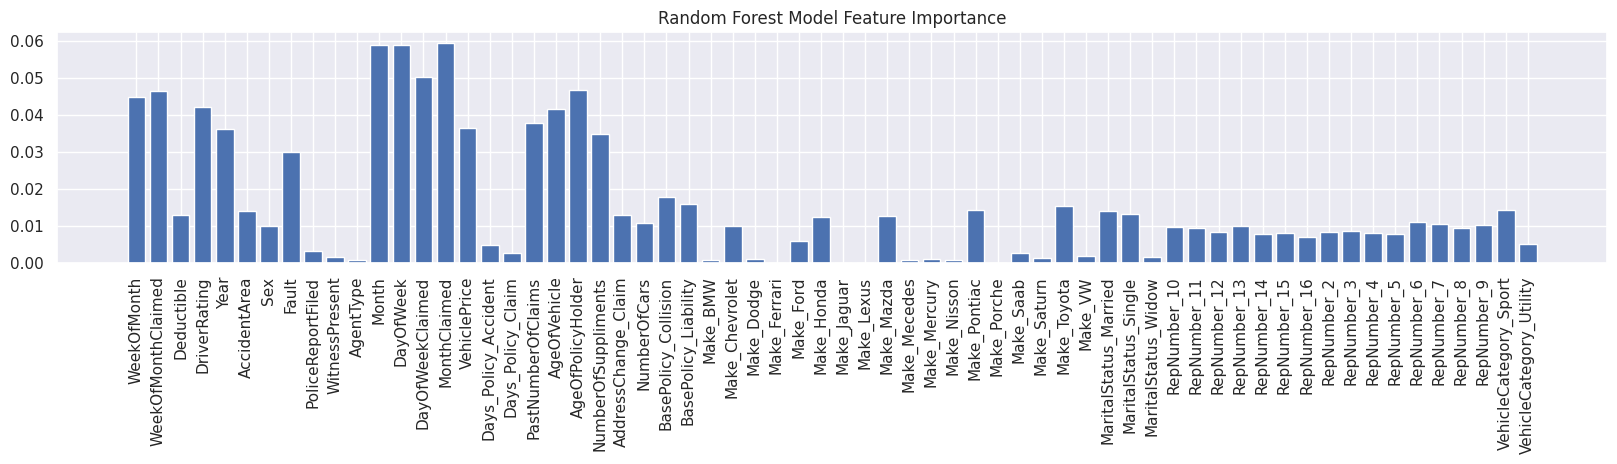

In [34]:
model = RandomForestClassifier()
model.fit(XtrainT, ytrainT)

features = XtrainT.columns.tolist()

feature_df = pd.DataFrame({"Importance":model.feature_importances_,
"Features": features })
sns.set()
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(feature_df["Features"], feature_df["Importance"])
plt.xticks(rotation=90)
plt.title("Random Forest Model Feature Importance")
plt.show()

In [35]:
#Se ordenan las variables en orden de importancia y se genera el listado

sorted_features = feature_df.sort_values(by='Importance', ascending=False)['Features'].tolist()

print("Las variables en orden de importancia aplicando Random Forest son: ")
display(sorted_features)


Las variables en orden de importancia aplicando Random Forest son: 


['MonthClaimed',
 'Month',
 'DayOfWeek',
 'DayOfWeekClaimed',
 'AgeOfPolicyHolder',
 'WeekOfMonthClaimed',
 'WeekOfMonth',
 'DriverRating',
 'AgeOfVehicle',
 'PastNumberOfClaims',
 'VehiclePrice',
 'Year',
 'NumberOfSuppliments',
 'Fault',
 'BasePolicy_Collision',
 'BasePolicy_Liability',
 'Make_Toyota',
 'Make_Pontiac',
 'VehicleCategory_Sport',
 'AccidentArea',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'AddressChange_Claim',
 'Deductible',
 'Make_Mazda',
 'Make_Honda',
 'RepNumber_6',
 'NumberOfCars',
 'RepNumber_7',
 'RepNumber_9',
 'Make_Chevrolet',
 'Sex',
 'RepNumber_13',
 'RepNumber_10',
 'RepNumber_11',
 'RepNumber_8',
 'RepNumber_3',
 'RepNumber_12',
 'RepNumber_2',
 'RepNumber_15',
 'RepNumber_4',
 'RepNumber_5',
 'RepNumber_14',
 'RepNumber_16',
 'Make_Ford',
 'VehicleCategory_Utility',
 'Days_Policy_Accident',
 'PoliceReportFiled',
 'Make_Saab',
 'Days_Policy_Claim',
 'Make_VW',
 'WitnessPresent',
 'MaritalStatus_Widow',
 'Make_Saturn',
 'Make_Mercury',
 'Make_Dod

In [36]:
# Extraemos las primeras 46 variables y las ordenamos alfabéticamente para compararlas con las obtenidas mediante PCA

sorted_features_46 = sorted_features[0:46]
sorted_features_46.sort()
sorted_features_46

['AccidentArea',
 'AddressChange_Claim',
 'AgeOfPolicyHolder',
 'AgeOfVehicle',
 'BasePolicy_Collision',
 'BasePolicy_Liability',
 'DayOfWeek',
 'DayOfWeekClaimed',
 'Deductible',
 'DriverRating',
 'Fault',
 'Make_Chevrolet',
 'Make_Ford',
 'Make_Honda',
 'Make_Mazda',
 'Make_Pontiac',
 'Make_Toyota',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'Month',
 'MonthClaimed',
 'NumberOfCars',
 'NumberOfSuppliments',
 'PastNumberOfClaims',
 'RepNumber_10',
 'RepNumber_11',
 'RepNumber_12',
 'RepNumber_13',
 'RepNumber_14',
 'RepNumber_15',
 'RepNumber_16',
 'RepNumber_2',
 'RepNumber_3',
 'RepNumber_4',
 'RepNumber_5',
 'RepNumber_6',
 'RepNumber_7',
 'RepNumber_8',
 'RepNumber_9',
 'Sex',
 'VehicleCategory_Sport',
 'VehicleCategory_Utility',
 'VehiclePrice',
 'WeekOfMonth',
 'WeekOfMonthClaimed',
 'Year']

##**Como podemos ver, las variables obtenidas mediante Random Forest son casi las mismas que las obtenidas con PCA**

Creamos una lista que combine ambas variables

In [37]:
# Se unifican las listas de las variables obtenidas mediante PCA con las variables obtenidas mediante Random Forest

combined_vars = []
for var in unique_vars:
  if var not in combined_vars:
    combined_vars.append(var)
for var in sorted_features_46:
  if var not in combined_vars:
    combined_vars.append(var)

combined_vars


['AccidentArea',
 'AddressChange_Claim',
 'AgeOfPolicyHolder',
 'AgeOfVehicle',
 'BasePolicy_Collision',
 'BasePolicy_Liability',
 'DayOfWeek',
 'DayOfWeekClaimed',
 'DriverRating',
 'Fault',
 'Make_Chevrolet',
 'Make_Ford',
 'Make_Honda',
 'Make_Mazda',
 'Make_Pontiac',
 'Make_Toyota',
 'Make_VW',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'Month',
 'MonthClaimed',
 'NumberOfCars',
 'NumberOfSuppliments',
 'PastNumberOfClaims',
 'RepNumber_10',
 'RepNumber_11',
 'RepNumber_12',
 'RepNumber_13',
 'RepNumber_14',
 'RepNumber_15',
 'RepNumber_16',
 'RepNumber_2',
 'RepNumber_3',
 'RepNumber_4',
 'RepNumber_5',
 'RepNumber_6',
 'RepNumber_7',
 'RepNumber_8',
 'RepNumber_9',
 'Sex',
 'VehicleCategory_Sport',
 'VehicleCategory_Utility',
 'VehiclePrice',
 'WeekOfMonth',
 'WeekOfMonthClaimed',
 'Year',
 'Deductible']

In [38]:
print("El número de variables más significatiivas tanto para el análisis de PCA como para el análisis de Random Forest es: " + str(len(combined_vars)))


El número de variables más significatiivas tanto para el análisis de PCA como para el análisis de Random Forest es: 47


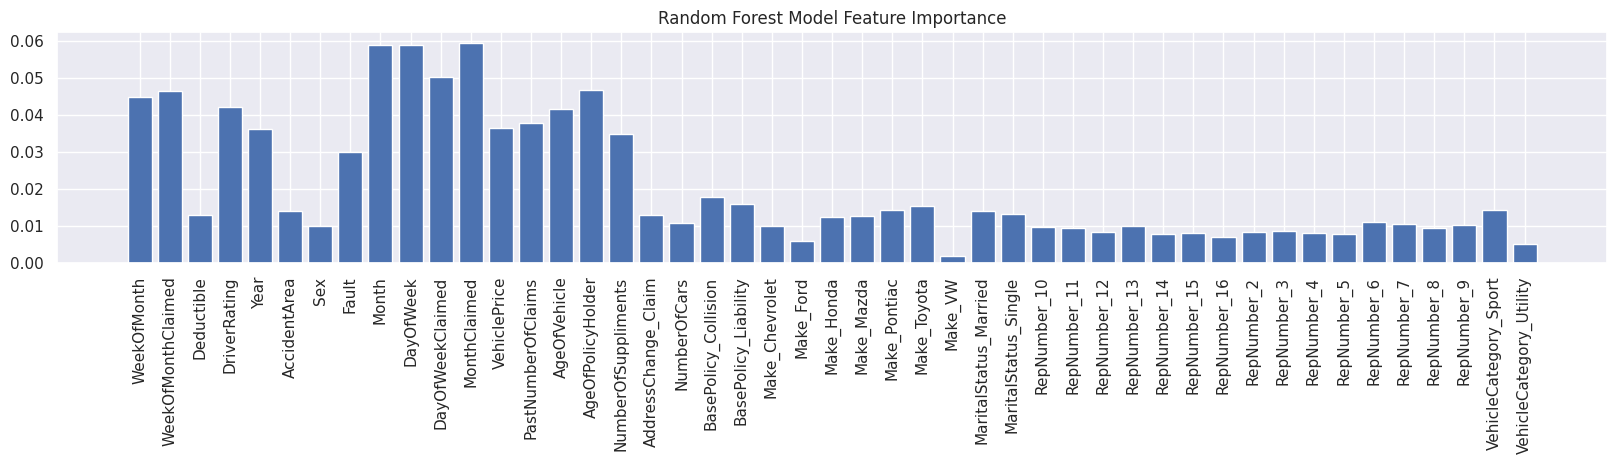

In [39]:
# Se crea un dataframe con los resultados del análisis de Random Forest que contenga solamente las variables de la lusta anterior

feature_df_copy = feature_df.copy()

filtered_feature_df = feature_df_copy[feature_df_copy['Features'].isin(combined_vars)]

# Se grafica el nuevo dataframe
sns.set()
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(filtered_feature_df["Features"], filtered_feature_df["Importance"])
plt.xticks(rotation=90)
plt.title("Random Forest Model Feature Importance")
plt.show()


Como se puede observar en la gráfica, de las variables obtenidas mediante PCA, solamente 'Make_VW' no es relevante en el análsis de Random Forest, por lo que podríamos considerar removerla más adelante.

#**Parte 3: Análisis mediante el cirterio de selección de factores por importancia de los mismos empleando Regresión Logística como estimador**

In [40]:
# Indicamos el modelo que se usará para evaluar la importancia de los factores

fs = SelectFromModel(estimator=LogisticRegression(), max_features=None)

# ajustamos con  los datos de entrenamiento para determinar cuáles se consideran los más relevantes:
fs.fit(XtrainT, np.ravel(ytrainT))

# y ahora obtenemos los factores
factor_select = fs.get_support(indices=True)

# Convert factor_select to a list to use for indexing
selected_features_3 = [features[i] for i in factor_select]

print(f"The {len(selected_features_3)} Features selected by SelectFromModel: {sorted(selected_features_3)}")

The 22 Features selected by SelectFromModel: ['AddressChange_Claim', 'AgeOfPolicyHolder', 'AgeOfVehicle', 'AgentType', 'BasePolicy_Collision', 'BasePolicy_Liability', 'Days_Policy_Accident', 'Deductible', 'Fault', 'Make_Chevrolet', 'Make_Dodge', 'Make_Honda', 'Make_Mazda', 'Make_Mercury', 'Make_Nisson', 'Make_Pontiac', 'Make_Toyota', 'Make_VW', 'MaritalStatus_Widow', 'NumberOfCars', 'PoliceReportFiled', 'VehicleCategory_Sport']


## Como se puede ver, la mayoría de las variables obtenidas mediante este análisis con Regresión Logística, ya se encuentran en la lista obtenida previamente mediante PCA y Random Forest

In [41]:
# prompt: I have two lists: 'combined_vars' and 'selected_features_3'. Generate a script that includes all the items in both lists only once

# Assuming 'combined_vars' and 'selected_features_3' are defined as in your provided code.

# Create a set from 'combined_vars' to efficiently check for membership
combined_set = set(combined_vars)

# Iterate through 'selected_features_3' and add elements not in the combined set
for feature in selected_features_3:
  if feature not in combined_set:
    combined_vars.append(feature)

# Convert back to a list and remove duplicates
combined_vars = list(set(combined_vars))

#Print the combined and unique list
print(f"The combined and unique list of variables is: {sorted(combined_vars)}")

# You can now use the 'combined_vars' list, which contains unique elements from both lists.


The combined and unique list of variables is: ['AccidentArea', 'AddressChange_Claim', 'AgeOfPolicyHolder', 'AgeOfVehicle', 'AgentType', 'BasePolicy_Collision', 'BasePolicy_Liability', 'DayOfWeek', 'DayOfWeekClaimed', 'Days_Policy_Accident', 'Deductible', 'DriverRating', 'Fault', 'Make_Chevrolet', 'Make_Dodge', 'Make_Ford', 'Make_Honda', 'Make_Mazda', 'Make_Mercury', 'Make_Nisson', 'Make_Pontiac', 'Make_Toyota', 'Make_VW', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow', 'Month', 'MonthClaimed', 'NumberOfCars', 'NumberOfSuppliments', 'PastNumberOfClaims', 'PoliceReportFiled', 'RepNumber_10', 'RepNumber_11', 'RepNumber_12', 'RepNumber_13', 'RepNumber_14', 'RepNumber_15', 'RepNumber_16', 'RepNumber_2', 'RepNumber_3', 'RepNumber_4', 'RepNumber_5', 'RepNumber_6', 'RepNumber_7', 'RepNumber_8', 'RepNumber_9', 'Sex', 'VehicleCategory_Sport', 'VehicleCategory_Utility', 'VehiclePrice', 'WeekOfMonth', 'WeekOfMonthClaimed', 'Year']


In [42]:
print("El número de variables más significatiivas tanto para el análisis de PCA como para el análisis de Random Forest y Regresión Logística es: " + str(len(combined_vars)))

El número de variables más significatiivas tanto para el análisis de PCA como para el análisis de Random Forest y Regresión Logística es: 54


##**Parte 4. Importancia de los factores mediante el Factor de Inflación de la Varianza (VIF)**

##Mediante el análisis de VIF se pretende detectar si existe multicolinealidad entre las variables hasta ahora seleccionadas, para eliminar de la lista aquellas que las que se detecte un alto índice de multicolinealidad (mayor a 10).

##Esto se hace calculando el índice VIF para cada variable y eliminando del dataframe la variable con mayor índice VIF (si es mayor a 10). A continuación, se calcula nuevamente el índice VIF para todas las variables y se elimina nuevamente la de mayor índice VIF (si es mayor a 10).

##Este proceso se repite hasta que el índice VIF de la variable con mayor índice VIF sea menor a 10.

In [46]:
# Definimos una función para estar evaluando el índice VIF:


def indice_vif(X):

    X = pd.DataFrame(X)  # nos aseguramos que las variable de entrada están en un DataFrame de Pandas.
    vif = pd.DataFrame()   # inicializamos el DataFRame de vif
    vif["factores"] = X.columns   # recuperamos todos los factores de nuestro conjunto de entrada
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  # FOR sobre las columnas/factores de X.

    return(vif)

In [44]:

# Create a new dataframe with only the columns in combined_vars
new_dataframe = XtrainT[combined_vars]

# Display the new dataframe (optional)
print(new_dataframe.head())


       Make_VW  VehiclePrice  AgeOfPolicyHolder  DriverRating  NumberOfCars  \
12012        0      0.586144           0.426461       0.52714      0.632997   
1149         0      0.458579           0.346786       0.52714      0.000000   
11427        0      0.458579           0.617384       0.47286      0.000000   
3476         0      0.556686           0.573539       0.47286      0.000000   
6678         0      0.458579           0.573539       0.52714      0.632997   

       RepNumber_15  Make_Ford  RepNumber_6  RepNumber_8  NumberOfSuppliments  \
12012             0          0            0            0             1.000000   
1149              0          0            0            0             0.513435   
11427             0          0            0            0             0.541421   
3476              0          1            0            0             0.000000   
6678              0          0            0            0             0.513435   

       ...  WeekOfMonth  BasePolicy_Co

In [47]:
indice_vif(new_dataframe)

,factores,VIF
0,Make_VW,1.425079
1,VehiclePrice,8.577341
2,AgeOfPolicyHolder,26.288919
3,DriverRating,2.950082
4,NumberOfCars,2.120299
5,RepNumber_15,1.996104
6,Make_Ford,1.693586
7,RepNumber_6,1.993638
8,RepNumber_8,1.962492
9,NumberOfSuppliments,2.061188


In [48]:

# Remove the column 'Days_Policy_Accident' permanently.

new_dataframe = new_dataframe.drop('Days_Policy_Accident', axis=1)

indice_vif(new_dataframe)


,factores,VIF
0,Make_VW,1.415833
1,VehiclePrice,8.483231
2,AgeOfPolicyHolder,25.987973
3,DriverRating,2.944605
4,NumberOfCars,2.119071
5,RepNumber_15,1.984177
6,Make_Ford,1.680467
7,RepNumber_6,1.980635
8,RepNumber_8,1.946700
9,NumberOfSuppliments,2.052185


In [49]:
new_dataframe = new_dataframe.drop('MaritalStatus_Married', axis=1)

indice_vif(new_dataframe)

,factores,VIF
0,Make_VW,1.397701
1,VehiclePrice,8.135454
2,AgeOfPolicyHolder,24.738548
3,DriverRating,2.921780
4,NumberOfCars,2.116563
5,RepNumber_15,1.926424
6,Make_Ford,1.622344
7,RepNumber_6,1.918904
8,RepNumber_8,1.886835
9,NumberOfSuppliments,2.051187


In [50]:
new_dataframe = new_dataframe.drop('Deductible', axis=1)

indice_vif(new_dataframe)

,factores,VIF
0,Make_VW,1.375126
1,VehiclePrice,7.829335
2,AgeOfPolicyHolder,23.436245
3,DriverRating,2.899771
4,NumberOfCars,2.111610
5,RepNumber_15,1.886681
6,Make_Ford,1.572044
7,RepNumber_6,1.876512
8,RepNumber_8,1.844590
9,NumberOfSuppliments,2.051059


In [51]:
new_dataframe = new_dataframe.drop('AgeOfPolicyHolder', axis=1)

indice_vif(new_dataframe)

,factores,VIF
0,Make_VW,1.360201
1,VehiclePrice,7.828460
2,DriverRating,2.893408
3,NumberOfCars,2.111450
4,RepNumber_15,1.862040
5,Make_Ford,1.546946
6,RepNumber_6,1.855754
7,RepNumber_8,1.819521
8,NumberOfSuppliments,2.045931
9,RepNumber_10,1.894581


In [52]:
new_dataframe = new_dataframe.drop('BasePolicy_Liability', axis=1)

indice_vif(new_dataframe)

,factores,VIF
0,Make_VW,1.355923
1,VehiclePrice,7.487831
2,DriverRating,2.893380
3,NumberOfCars,2.111352
4,RepNumber_15,1.860407
5,Make_Ford,1.544880
6,RepNumber_6,1.852519
7,RepNumber_8,1.817337
8,NumberOfSuppliments,2.040418
9,RepNumber_10,1.892151


In [53]:
new_dataframe = new_dataframe.drop('MonthClaimed', axis=1)

indice_vif(new_dataframe)

,factores,VIF
0,Make_VW,1.355571
1,VehiclePrice,7.487761
2,DriverRating,2.891831
3,NumberOfCars,2.111092
4,RepNumber_15,1.857960
5,Make_Ford,1.543861
6,RepNumber_6,1.848153
7,RepNumber_8,1.813427
8,NumberOfSuppliments,2.038502
9,RepNumber_10,1.890662


In [54]:
# Create a list with the names of all the columns in this dataframe

final_features_list = new_dataframe.columns.tolist()
final_features_list


['Make_VW',
 'VehiclePrice',
 'DriverRating',
 'NumberOfCars',
 'RepNumber_15',
 'Make_Ford',
 'RepNumber_6',
 'RepNumber_8',
 'NumberOfSuppliments',
 'RepNumber_10',
 'Month',
 'MaritalStatus_Single',
 'AccidentArea',
 'Make_Mazda',
 'MaritalStatus_Widow',
 'RepNumber_2',
 'AgentType',
 'RepNumber_13',
 'RepNumber_16',
 'Make_Mercury',
 'RepNumber_5',
 'DayOfWeekClaimed',
 'Fault',
 'AgeOfVehicle',
 'Make_Toyota',
 'VehicleCategory_Sport',
 'RepNumber_4',
 'Make_Dodge',
 'PoliceReportFiled',
 'RepNumber_11',
 'Make_Chevrolet',
 'PastNumberOfClaims',
 'RepNumber_3',
 'Year',
 'Sex',
 'VehicleCategory_Utility',
 'RepNumber_7',
 'RepNumber_12',
 'AddressChange_Claim',
 'WeekOfMonthClaimed',
 'Make_Honda',
 'WeekOfMonth',
 'BasePolicy_Collision',
 'DayOfWeek',
 'RepNumber_9',
 'Make_Pontiac',
 'Make_Nisson',
 'RepNumber_14']

In [55]:
print("El número de variables despúes de remover las de índice VIF mayor a 10 es: " + str(len(final_features_list)))

El número de variables despúes de remover las de índice VIF mayor a 10 es: 48


In [57]:
# Create three new dataframes with only the columns in final_features_list
XtrainT_reduc = XtrainT[final_features_list]
XvalT_reduc = XvalT[final_features_list]
XtestT_reduc = XtestT[final_features_list]

# Display the new dataframes (optional)
print(XtrainT_reduc.head())
print(XvalT_reduc.head())
print(XtestT_reduc.head())


       Make_VW  VehiclePrice  DriverRating  NumberOfCars  RepNumber_15  \
12012        0      0.586144       0.52714      0.632997             0   
1149         0      0.458579       0.52714      0.000000             0   
11427        0      0.458579       0.47286      0.000000             0   
3476         0      0.556686       0.47286      0.000000             0   
6678         0      0.458579       0.52714      0.632997             0   

       Make_Ford  RepNumber_6  RepNumber_8  NumberOfSuppliments  RepNumber_10  \
12012          0            0            0             1.000000             0   
1149           0            0            0             0.513435             0   
11427          0            0            0             0.541421             0   
3476           1            0            0             0.000000             0   
6678           0            0            0             0.513435             0   

       ...  AddressChange_Claim  WeekOfMonthClaimed  Make_Honda  Wee

In [75]:
# Desplegando la matriz de confusión:
# (etiquetas_reales, etiquetas_de_predicciones)
def mi_cm(yreal, ypred):
  cm = confusion_matrix(yreal, ypred)

  txt = ['Verdaderos Negativos','Falsos Positivos','Falsos Negativos','Verdaderos Positivos']
  vf = [ '( VN )', '( FP )', '( FN )', '( VP )']
  frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
  porcentaje = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]

  labels = [f"{v1}\n{v2}\n{v3}\n{v4}" for v1, v2, v3, v4 in zip(txt,vf, frecuencia,porcentaje)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure(figsize=(6,4))
  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Pastel1', cbar=False)
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.show()

In [62]:
modelo = LogisticRegression(class_weight='balanced')   #Se indica que se haga la ponderación balanceada

# Entrenamos el modelo con los datos de entrenamiento:
modelo.fit(XtrainT_reduc, ytrainT.to_numpy().ravel())

yhat = cross_val_predict(modelo, XvalT_reduc, yvalT.to_numpy().ravel(), cv=10)

print ("La exactitud en el conjunto de validación es: " + str(accuracy_score(yvalT, yhat)))
print (" ")
print (classification_report(yvalT, yhat))

La exactitud en el conjunto de validación es: 0.6753134457414613
 
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      2174
           1       0.12      0.68      0.20       139

    accuracy                           0.68      2313
   macro avg       0.54      0.68      0.50      2313
weighted avg       0.92      0.68      0.76      2313



In [73]:
tabla = []

delta = np.linspace(.05, .4, 8)
tabla = list()

for w in delta:
  modeloCW = LogisticRegression(max_iter=10000, class_weight={0:w, 1:(1-w)}, C=.7)
  modeloCW.fit(XtrainT_reduc, ytrainT.to_numpy().ravel())
  yhat = modeloCW.predict(XvalT_reduc)

  acc = 100*modeloCW.score(XvalT_reduc,yvalT)

  cm = confusion_matrix(yvalT, yhat)

  tot = cm.sum()

  vn = 100*cm[0,0] / tot
  fp = 100*cm[0,1] / tot
  fn = 100*cm[1,0] / tot
  vp = 100*cm[1,1] / tot

  precision = vp / ( vp+fp)
  recall = vp / (vp+fn)
  f1score = 2*vp / (2*vp+fp+fn)
  especificidad = vn / (vn+fp)
  gmean = np.sqrt(recall * especificidad)

  tabla.append([w, (1-w), acc, vn, fp, fn, vp, precision, recall, f1score, gmean])

print(tabulate(tabla,
         headers=["w (clase 0)","(1-w) (clase 1)","Exact(%)", "VN(%)", "FP(%)", "FN(%)", "VP(%)", "precision", "recall", "f1score", "gmean"],
         tablefmt="github",
         floatfmt=".2f"
         ))

|   w (clase 0) |   (1-w) (clase 1) |   Exact(%) |   VN(%) |   FP(%) |   FN(%) |   VP(%) |   precision |   recall |   f1score |   gmean |
|---------------|-------------------|------------|---------|---------|---------|---------|-------------|----------|-----------|---------|
|          0.05 |              0.95 |      61.65 |   56.55 |   37.44 |    0.91 |    5.10 |        0.12 |     0.85 |      0.21 |    0.71 |
|          0.10 |              0.90 |      74.54 |   71.03 |   22.96 |    2.51 |    3.50 |        0.13 |     0.58 |      0.22 |    0.66 |
|          0.15 |              0.85 |      88.67 |   87.42 |    6.57 |    4.76 |    1.25 |        0.16 |     0.21 |      0.18 |    0.44 |
|          0.20 |              0.80 |      92.91 |   92.48 |    1.51 |    5.58 |    0.43 |        0.22 |     0.07 |      0.11 |    0.27 |
|          0.25 |              0.75 |      93.56 |   93.47 |    0.52 |    5.92 |    0.09 |        0.14 |     0.01 |      0.03 |    0.12 |
|          0.30 |              0.7

<ipython-input-73-58088e95448c>:22: RuntimeWarning: invalid value encountered in scalar divide
  precision = vp / ( vp+fp)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of thie model:		 0.9399048854301773


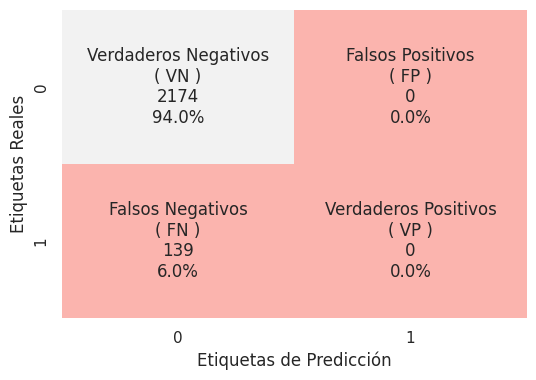

None


In [76]:
lr = LogisticRegression()
lr.fit(XtrainT,ytrainT)
lr_pred = lr.predict(XvalT)

acc_lr=accuracy_score(yvalT, lr_pred)
print("Accuracy of thie model:\t\t",acc_lr)
print(mi_cm(yvalT,lr_pred))

In [84]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

pipe = Pipeline(steps=[('rus', RandomUnderSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('xgb', XGBClassifier(eta=0.1, gamma=3, max_depth=10, enable_categorical=True,
                          # tree_method='gpu_hist',  # Comment out this line to disable GPU usage
                          n_estimators=1000,
                          reg_alpha=0.005, validate_parameters=True))])

In [85]:
pipe.fit(XtrainT_reduc, ytrainT)

Pipeline(steps=[('rus', RandomUnderSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=3,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [87]:
from sklearn.model_selection import cross_validate # Importing cross_validate function
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

pipe = Pipeline(steps=[('rus', RandomUnderSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('xgb', XGBClassifier(eta=0.1, gamma=3, max_depth=10, enable_categorical=True,
                          # tree_method='gpu_hist',  # Comment out this line to disable GPU usage
                          n_estimators=1000,
                          reg_alpha=0.005, validate_parameters=True))])

pipe.fit(XtrainT_reduc, ytrainT) # Assuming XtrainT_reduc is the correct variable

# Calling cross_validate with correct variable name
cross_validate(pipe, XtrainT_reduc, ytrainT) # Changed XtrainT_reduc_ to XtrainT_reduc

{'fit_time': array([0.22787809, 0.21557045, 0.21331143, 0.21474862, 0.25571275]),
 'score_time': array([0.01888561, 0.04505229, 0.01920891, 0.01747775, 0.01654887]),
 'test_score': array([0.65446966, 0.66743863, 0.62575266, 0.62575266, 0.61167748])}

In [91]:
pred_pipe = pipe.predict(XvalT_reduc)

In [92]:
print(classification_report(yvalT, pred_pipe))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76      2174
           1       0.13      0.94      0.24       139

    accuracy                           0.64      2313
   macro avg       0.56      0.78      0.50      2313
weighted avg       0.94      0.64      0.73      2313



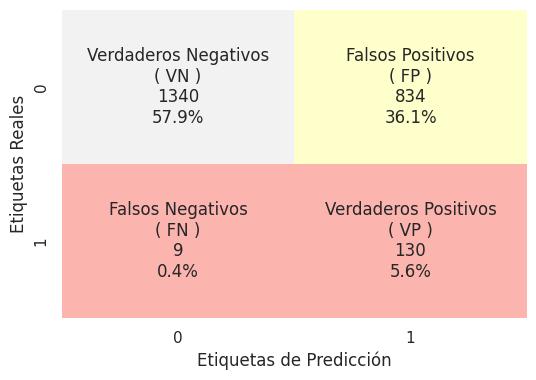

None


In [93]:
print(mi_cm(yvalT,pred_pipe))

In [94]:
pred_pipe = pipe.predict(XtestT_reduc)

In [95]:
print(classification_report(ytestT, pred_pipe))

              precision    recall  f1-score   support

           0       1.00      0.61      0.76      2175
           1       0.14      0.96      0.24       138

    accuracy                           0.63      2313
   macro avg       0.57      0.79      0.50      2313
weighted avg       0.94      0.63      0.73      2313



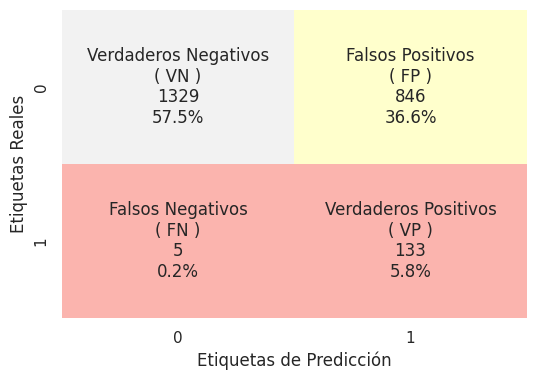

None


In [96]:
print(mi_cm(ytestT,pred_pipe))